# imports

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import argparse
import os
import random
import glob
import json
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
from torch.utils.data.dataset import Dataset  # For custom data-sets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl

#on HPC, we can check whether we have GPU support here---------------------------------------------------------------------------------------------
assert torch.cuda.is_available()
print(60*'-')
print('Found GPU at: {}'.format(torch.cuda.get_device_name(0)))
print(60*'-')
torch.cuda.empty_cache()

------------------------------------------------------------
Found GPU at: Tesla V100-SXM2-16GB
------------------------------------------------------------


In [ ]:
os.chdir("/content/drive/MyDrive/Carlos_Research/GAN_nanop/HPC_models")

In [ ]:
!pwd

/content/drive/MyDrive/Carlos_Research/GAN_nanop/HPC_models


# define inputs

In [ ]:
dataroot = "../../particle_data/images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 36
  # using 64 results in a out-of-memory error for CUDA

# Spatial size of training images. All images will be cropped to this size using a transformer.
image_size = 512

# Number of channels in the training images. For color images this is 3, for our grayscale image is 1
nc = 1

# Size/length of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator, i.e. # of channels of the kernel
ngf = 64

# Size of feature maps in discriminator, i.e. # of channels of the kernel
ndf = 64

# Number of training epochs
num_epochs = 100

# Learning rate for optimizers
lr = 0.0002
  # smaller batch number, slightly larger learning rate?

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1# Decide which device we want to run on

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("device:", device)

device: cuda:0


# define Generator

In [ ]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is latent vector Z of shape (nz x 1 x 1), going into a convolution
            nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 16),
            nn.ReLU(True),
              # state size. (ngf*16) x 4 x 4, where 4 = n+k-1= 1+4-1
              # to figure out the dimension of convtrans, just ask what dimension with the current setting gets you the current dimension
            nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
              # state size. (ngf*8) x 8 x 8, where 8 = (n-1)*s+k-2p = 3*2+4-2
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
              # state size. (ngf*4) x 16 x 16, where 16 = (n-1)*s+k-2p = 7*2+4-2
            nn.ConvTranspose2d( ngf * 4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
              # state size. (ngf*2) x 32 x 32, where 32 = (n-1)*s+k-2p = 15*2+4-2
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 64 x 64, where 64 = (n-1)*s+k-2p = 31*2+4-2
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 128 x 128, where 128 = (n-1)*s+k-2p = 63*2+4-2
            nn.ConvTranspose2d(ngf, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
              # state size. (ngf) x 256 x 256, where 256 = (n-1)*s+k-2p = 127*2+4-2
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
              # state size. (nc) x 512 x 512, where 512 = (n-1)*s+k-2p = 255*2+4-2
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)

# `G_D_loss` plots

In [ ]:
with open("logs.json", 'r') as fp:
  logs = json.load(fp)
G_losses = logs["G_losses"]
D_losses = logs["D_losses"]

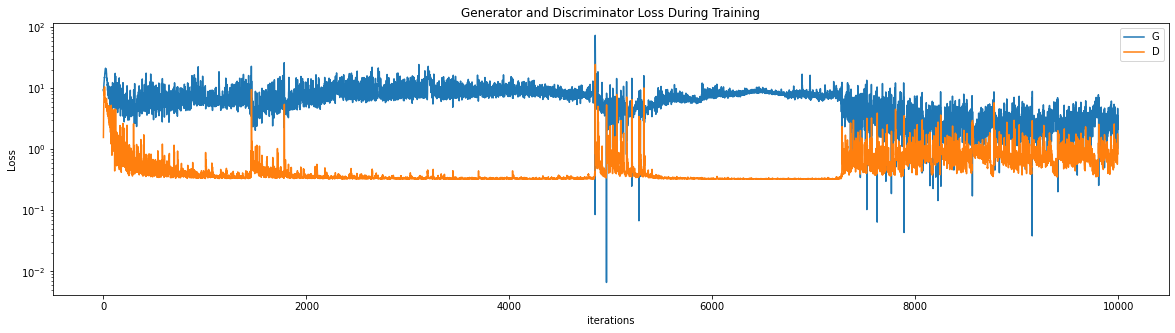

plotted the model losses


In [ ]:
plt.figure(figsize=(int(10*2),5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses[:10000],label="G")
plt.plot(D_losses[:10000],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.yscale('log')
plt.legend()
# plt.savefig(pwd+"/result_figs/GD_loss_plot")
plt.show()
print("plotted the model losses")

# load `nz=50` model

## testing with `batch_size`

In [ ]:
G_50 = torch.load("nz50_e200_G");

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, Sourc

In [ ]:
batch_size=1

In [ ]:
nz = 50

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())
print("norm: ", torch.norm(noise).item())

mean:  -0.06464283168315887
std:  1.0118662118911743
norm:  7.09779691696167


In [ ]:
with torch.no_grad():
  fake = G_50(noise).detach().cpu()

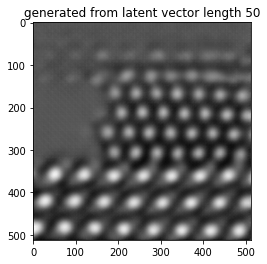

In [ ]:
plt.figure(figsize=(4,4))
plt.title("generated from latent vector length 50")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)

In [ ]:
# eval() mode on the same noise vector

In [ ]:
with torch.no_grad():
  G_50.eval()
  fake = G_50(noise).detach().cpu()

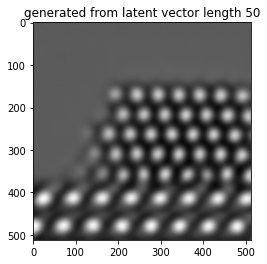

In [ ]:
plt.figure(figsize=(4,4))
plt.title("generated from latent vector length 50")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)

In [ ]:
# so we should always set the model to evaluation mode when doing validations
# although, if you use a larger batch_size, the batch statistics will be closer to population statistics 
# so it should be less of a problem

## `batch_size=36`

In [ ]:
batch_size=36

In [ ]:
nz = 50

In [ ]:
G_50 = torch.load("nz50_e200_G")

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())
print("norm: ", torch.norm(noise).item())

mean:  -0.0005403720424510539
std:  0.9902185797691345
norm:  41.99974822998047


In [ ]:
with torch.no_grad():
  fake = G_50(noise).detach().cpu()

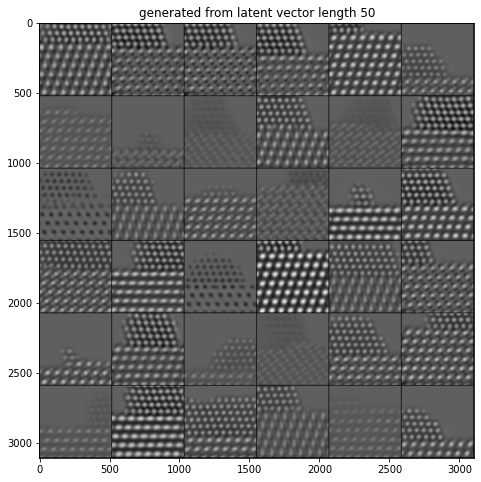

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 50")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)

## non-Gaussian noise

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
noise = noise*5+5
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())
print("norm: ", torch.norm(noise).item())

mean:  4.940359592437744
std:  4.945498943328857
norm:  296.5345458984375


In [ ]:
with torch.no_grad():
  fake = G_50(noise).detach().cpu()

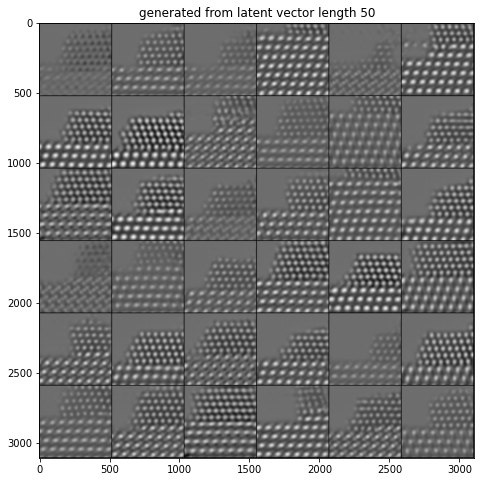

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 50")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)

# load `nz=100` model

In [ ]:
nz = 100

In [ ]:
G_100 = torch.load("nz100_e400_G")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, Sourc

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())
print("norm: ", torch.norm(noise).item())

mean:  -0.009360233321785927
std:  1.0128648281097412


In [ ]:
with torch.no_grad():
  fake = G_100(noise).detach().cpu()

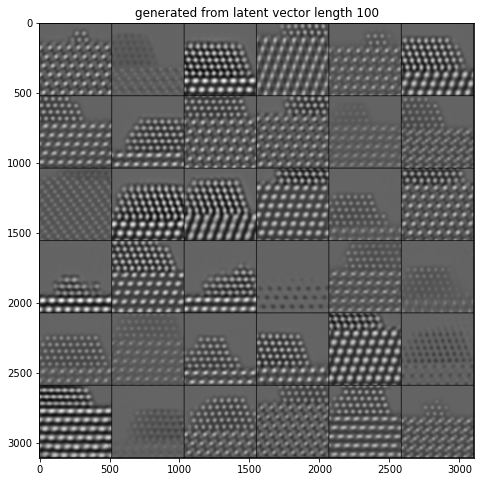

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 100")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)

## non-Gaussian noise

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
noise = noise*5+10
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())
print("norm: ", torch.norm(noise).item())

mean:  9.936327934265137
std:  4.895531177520752


In [ ]:
with torch.no_grad():
  fake = G_50(noise).detach().cpu()

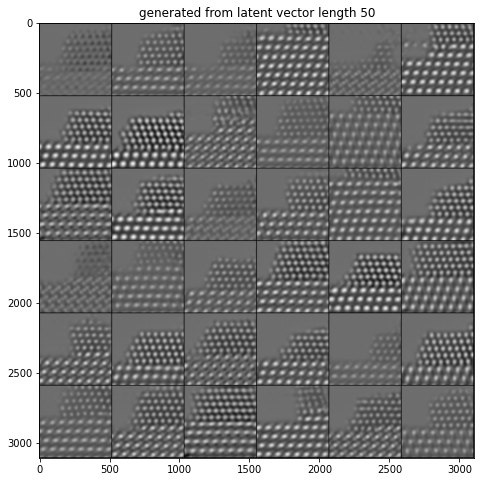

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 50")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)

# load `nz=150` model

In [ ]:
nz = 150

In [ ]:
G_150 = torch.load("nz150_e400_G")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:625: UserWarning: Couldn't retrieve source code for container of type Generator. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:658: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, Sourc

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())
print("norm: ", torch.norm(noise).item())

mean:  -0.03155913203954697
std:  0.9986440539360046
norm:  73.4148941040039


In [ ]:
with torch.no_grad():
  fake = G_150(noise).detach().cpu()

In [ ]:
print("mean: ", torch.mean(fake).item())
print("std: ", torch.std(fake).item())
print("min: ", torch.min(fake).item())
print("max: ", torch.max(fake).item())

mean:  -0.11759386956691742
std:  0.11488176137208939
min:  -0.6068346500396729
max:  0.5890268087387085


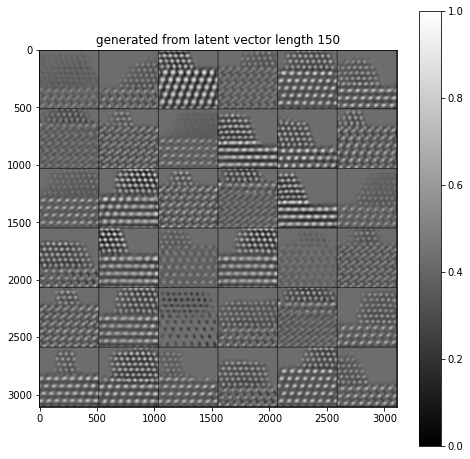

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 150")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar()

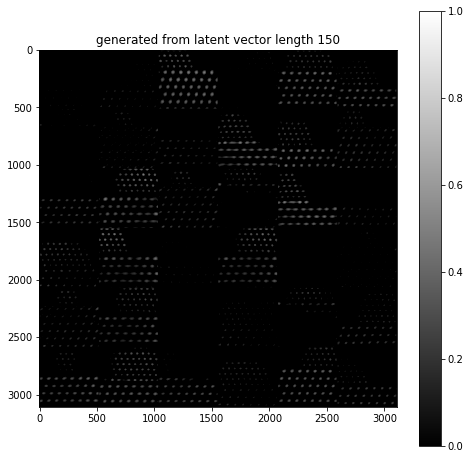

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 150")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=False)[0], cmap='gray', vmin=0, vmax=1)
plt.colorbar()

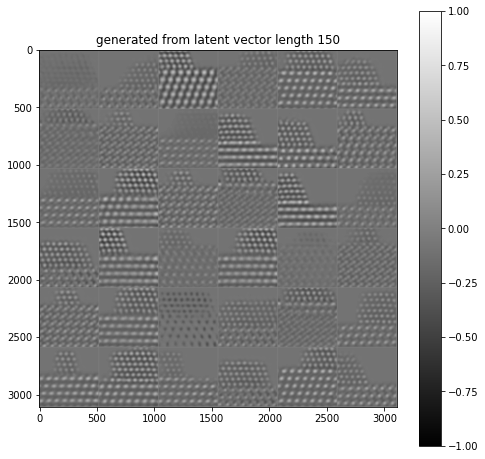

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 150")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=False)[0], cmap='gray', vmin=-1, vmax=1)
plt.colorbar()

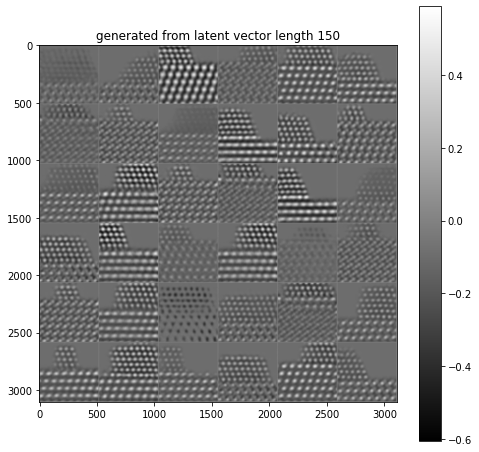

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 150")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=False)[0], cmap='gray')
plt.colorbar()

In [ ]:
fake_back = fake*0.5 + 0.5
print("mean: ", torch.mean(fake_back).item())
print("std: ", torch.std(fake_back).item())
print("min: ", torch.min(fake_back).item())
print("max: ", torch.max(fake_back).item())

mean:  0.4412030279636383
std:  0.05744088068604469
min:  0.19658267498016357
max:  0.7945134043693542


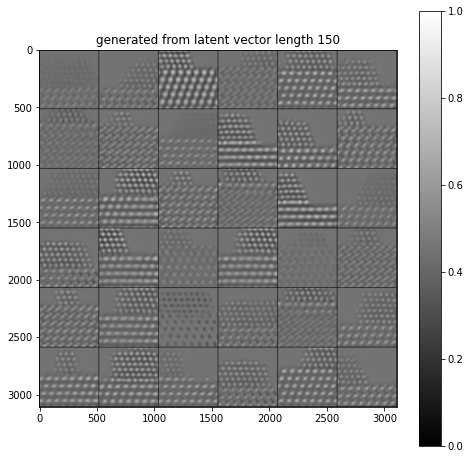

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 150")
plt.imshow(vutils.make_grid(fake_back, nrow=6, padding=5, normalize=False)[0], cmap='gray', vmin=0, vmax=1)
  # this looks the same as fake plotted from [-1, 1]
  # but both are less defined than the re-normalized, since the re-normalized did not hold true to the original input scale
  # it exagerrated the contrast between max and min
plt.colorbar()

In [ ]:
fake_back2 = transforms.Normalize(-1, 2)(fake)
print("mean: ", torch.mean(fake_back2).item())
print("std: ", torch.std(fake_back2).item())
print("min: ", torch.min(fake_back2).item())
print("max: ", torch.max(fake_back2).item())

mean:  0.4412030279636383
std:  0.05744088068604469
min:  0.19658267498016357
max:  0.7945134043693542


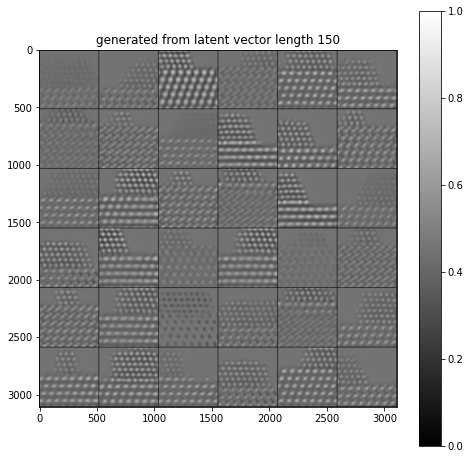

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 150")
plt.imshow(vutils.make_grid(fake_back2, nrow=6, padding=5, normalize=False)[0], cmap='gray', vmin=0, vmax=1)
  # this looks the same as fake plotted from [-1, 1]
  # and this is the same as the inverse scaling above
plt.colorbar()

## non-Gaussian noise

In [ ]:
noise = torch.randn(batch_size, nz, 1, 1, device=device)
noise = noise*5+10
print("mean: ", torch.mean(noise).item())
print("std: ", torch.std(noise).item())

mean:  9.936327934265137
std:  4.895531177520752


In [ ]:
with torch.no_grad():
  fake = G_50(noise).detach().cpu()

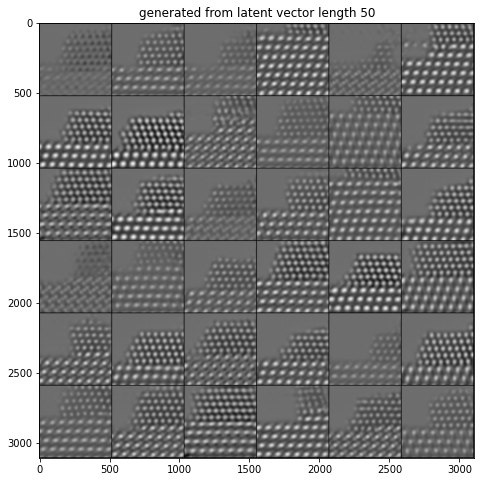

In [ ]:
plt.figure(figsize=(8,8))
plt.title("generated from latent vector length 50")
plt.imshow(vutils.make_grid(fake, nrow=6, padding=5, normalize=True)[0], cmap='gray', vmin=0, vmax=1)